# Consistency: CEBRA for consistent and interpretable embeddings

In this notebook, we show how to

- use CEBRA-Time and CEBRA-Behavior.
- diplay embeddings easily.
- compute and display the consistency between CEBRA embeddings.


It is mostly based on what we present in [Figure 1](https://cebra.ai/docs/cebra-figures/figures/Figure1.html).

**Install note**
- Be sure you have cebra and the dataset dependency installed to use this notebook on Colab:

In [ ]:
!pip install --pre 'cebra[datasets]'

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

## Load the data

- The data will be automatically downloaded into a `/data` folder.

In [3]:
%mkdir data
hippocampus_pos = {}
hippocampus_pos["achilles"] = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_pos["buddy"] = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_pos["cicero"] = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_pos["gatsby"] = cebra.datasets.init('rat-hippocampus-single-gatsby')

100%|██████████| 10.0M/10.0M [00:02<00:00, 4.84MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


100%|██████████| 2.68M/2.68M [00:07<00:00, 350kB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/buddy.jl'


100%|██████████| 22.0M/22.0M [00:03<00:00, 7.20MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/cicero.jl'


100%|██████████| 9.40M/9.40M [00:02<00:00, 4.27MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/gatsby.jl'


## Visualize the data

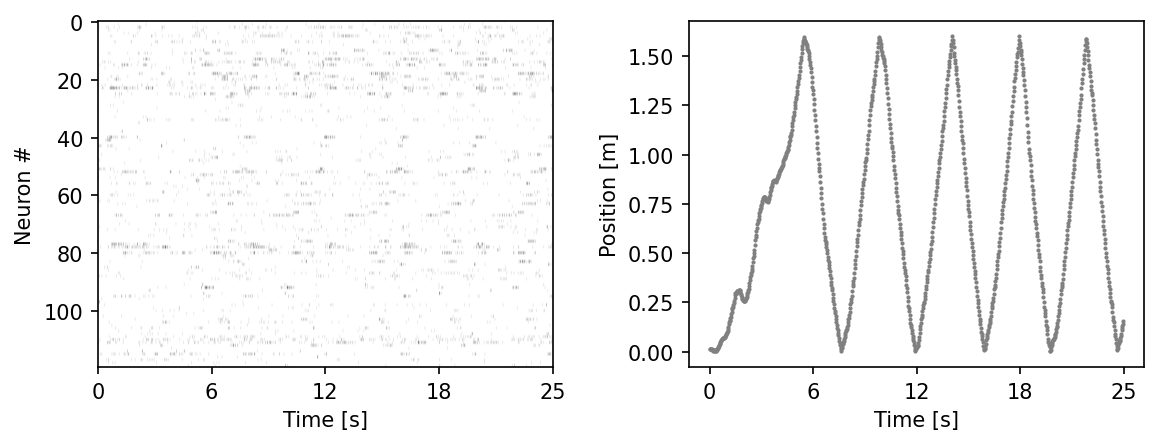

In [4]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

**------------------- BEGINNING OF TRAINING SECTION -------------------**

## Train the models

*[You can skip this section if you already have the models saved]*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [5]:
max_iterations = 8000 #default is 5000.

### CEBRA-Time: Train a model that uses time without the behavior information.
- We can use CEBRA -Time mode by setting conditional = 'time'
- We train the model with neural data only.

In [6]:
time_models, time_labels = [], []

for rat in list(hippocampus_pos.keys()):

    cebra_time3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1.12,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)

    cebra_time3_model.fit(hippocampus_pos[rat].neural)
    time_models.append(cebra_time3_model)
    time_labels.append(f"rat: {rat}")
    cebra_time3_model.save(f"cebra_time3_model_{rat}.pt")


pos: -0.8630 neg:  6.3688 total:  5.5058 temperature:  1.1200: 100%|██████████| 8000/8000 [01:24<00:00, 95.17it/s]
pos: -0.7751 neg:  6.3797 total:  5.6046 temperature:  1.1200: 100%|██████████| 8000/8000 [01:24<00:00, 95.16it/s]
pos: -0.5869 neg:  6.3746 total:  5.7877 temperature:  1.1200: 100%|██████████| 8000/8000 [01:24<00:00, 94.36it/s]
pos: -0.7880 neg:  6.3771 total:  5.5892 temperature:  1.1200: 100%|██████████| 8000/8000 [01:23<00:00, 95.78it/s]


ProTip: here you can look at the loss curves of the various models; given each dataset is a varying number of neurons and length, some might benefit from longer (or less) training iterations! To optimize this, you can monitor consistency across runs vs. training time.

Text(0.5, 1.0, 'Time Contrastive Learning')

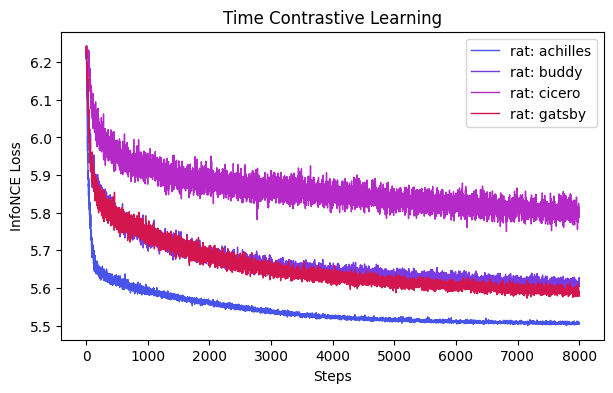

In [7]:
ax = cebra.compare_models(time_models, time_labels)
ax.set_title("Time Contrastive Learning")

### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.
- We train the model with neural data and the behavior variable including position and direction.

In [8]:
models, labels = [], []

for rat in list(hippocampus_pos.keys()):

    cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time_delta',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)

    cebra_posdir3_model.fit(hippocampus_pos[rat].neural, hippocampus_pos[rat].continuous_index.numpy())
    models.append(cebra_posdir3_model)
    labels.append(f"rat: {rat}")
    cebra_posdir3_model.save(f"cebra_posdir3_model_{rat}.pt")

pos: -0.9179 neg:  6.4157 total:  5.4978 temperature:  1.0000: 100%|██████████| 8000/8000 [01:25<00:00, 93.38it/s]
pos: -0.7738 neg:  6.4309 total:  5.6571 temperature:  1.0000: 100%|██████████| 8000/8000 [01:29<00:00, 89.00it/s]
pos: -0.5725 neg:  6.4554 total:  5.8829 temperature:  1.0000: 100%|██████████| 8000/8000 [01:27<00:00, 91.80it/s]
pos: -0.8525 neg:  6.4669 total:  5.6143 temperature:  1.0000: 100%|██████████| 8000/8000 [01:27<00:00, 91.86it/s]


Text(0.5, 1.0, 'Behavior(label)-guided Contrastive Learning')

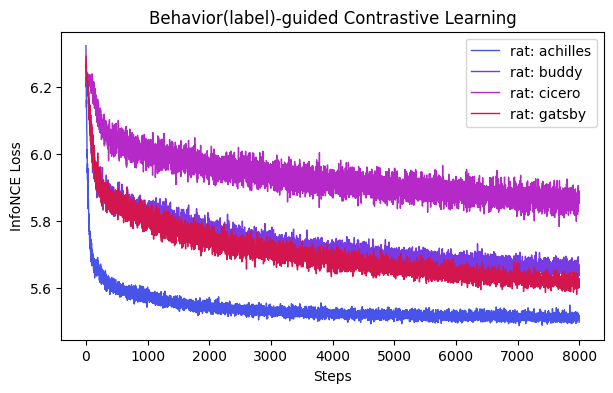

In [9]:
ax = cebra.compare_models(models, labels)
ax.set_title("Behavior(label)-guided Contrastive Learning")

**------------------- END OF TRAINING SECTION -------------------**

## Load the models and get the embeddings

In [10]:
time3_models, time3_embeddings = {}, {}
posdir3_models, posdir3_embeddings = {}, {}
left, right = {}, {}

for rat in list(hippocampus_pos.keys()):
    # time constrative models
    time3_models[rat] = cebra.CEBRA.load(f"cebra_time3_model_{rat}.pt")
    time3_embeddings[rat] = time3_models[rat].transform(hippocampus_pos[rat].neural)

    # behavioral contrastive models
    posdir3_models[rat] = cebra.CEBRA.load(f"cebra_posdir3_model_{rat}.pt")
    posdir3_embeddings[rat] = posdir3_models[rat].transform(hippocampus_pos[rat].neural)

    # left and right labels for the embedding
    right[rat] = hippocampus_pos[rat].continuous_index[:,1] == 1
    left[rat] = hippocampus_pos[rat].continuous_index[:,2] == 1

## Display the embeddings

**Note to Google Colaboratory users:** replace the first line of the next cell (``%matplotlib notebook``) with ``%matplotlib inline``.

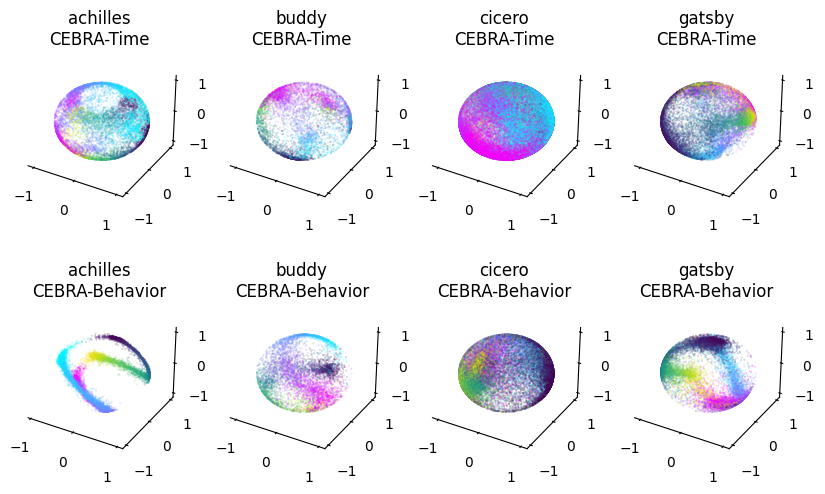

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

ax1 = plt.subplot(245, projection='3d')
ax2 = plt.subplot(246, projection='3d')
ax3 = plt.subplot(247, projection='3d')
ax4 = plt.subplot(248, projection='3d')
axs_down = [ax1, ax2, ax3, ax4]

for ax, rat in  zip(axs_up, list(time3_embeddings.keys())):
    for dir, cmap in zip([right[rat], left[rat]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=time3_embeddings[rat][dir,:], embedding_labels=hippocampus_pos[rat].continuous_index[dir,0], title=f"{rat}\nCEBRA-Time", cmap=cmap)

for ax, rat in  zip(axs_down, list(posdir3_embeddings.keys())):
    for dir, cmap in zip([right[rat], left[rat]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=posdir3_embeddings[rat][dir,:], embedding_labels=hippocampus_pos[rat].continuous_index[dir,0], title=f"{rat}\nCEBRA-Behavior", cmap=cmap)


plt.show()

## Compute the consistency maps

Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [12]:
# labels to align the subjects is the position of the rat in the arena
labels = [hippocampus_pos[rat].continuous_index[:, 0]
          for rat in list(hippocampus_pos.keys())]

# CEBRA-Time consistencies
time_scores, time_pairs, time_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(time3_embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=list(
                                                                                     time3_embeddings.keys()),
                                                                                 between="datasets")

# CEBRA-Behavior consistencies
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(posdir3_embeddings.values()),
                                                                                       labels=labels,
                                                                                       dataset_ids=list(
                                                                                           posdir3_embeddings.keys()),
                                                                                       between="datasets")


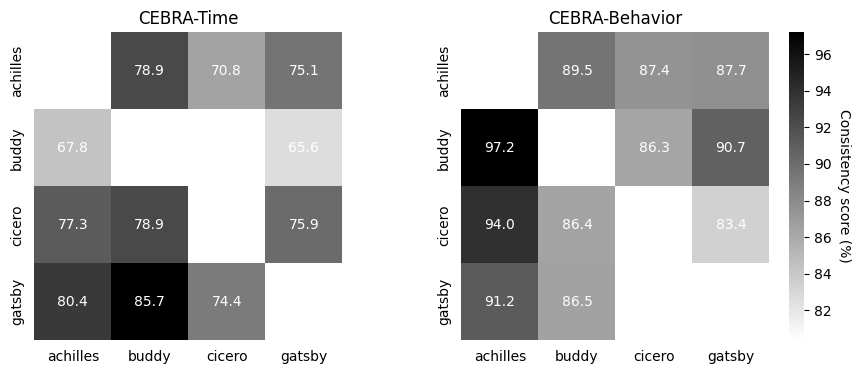

In [13]:
%matplotlib inline

# Display consistency maps
fig = plt.figure(figsize=(11, 4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1 = cebra.plot_consistency(time_scores, pairs=time_pairs, datasets=time_subjects,
                             ax=ax1, title="CEBRA-Time", colorbar_label=None)
ax2 = cebra.plot_consistency(
    posdir_scores, pairs=posdir_pairs, datasets=posdir_subjects, ax=ax2, title="CEBRA-Behavior")
